# ДЗ 2 По РИС ИНС

## Выполнил Леликов А.М. (9 вариант)

### Импортирование вспомогательных библиотек

In [468]:
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import statsmodels.api as sm

In [469]:
# Функция изменяющая вектор в кососиметрическую матрицу
def SkewSymmMatr(a: np.array) -> np.array:
    Ax = np.array(
        [[0.0, -a[2], a[1]],
         [a[2], 0.0, -a[0]],
         [-a[1], a[0], 0.0]])
    return Ax

# Векторное произведение
def cross(a: np.array, b: np.array) -> np.array:
    axb = SkewSymmMatr(a) @ b
    return axb

# огроничение для курса
def twoPiBound(heading: float) -> float:
    if heading < 0:
        heading = heading + 2.0 * np.pi
    return heading


# МНК BODY-> Navigation (ENUp)
def DCM_bn(heading: float, pitch: float, roll: float) -> np.array:

    sz = np.sin(-heading)
    cz = np.cos(-heading)
    sy = np.sin(roll)
    cy = np.cos(roll)
    sx = np.sin(pitch)
    cx = np.cos(pitch)

    Cx = np.array([[1, 0, 0], [0, cx, sx], [0, -sx, cx]], dtype=np.float64)
    Cy = np.array([[cy, 0, -sy], [0, 1, 0], [sy, 0, cy]], dtype=np.float64)
    Cz = np.array([[cz, sz, 0], [-sz, cz, 0], [0, 0, 1]], dtype=np.float64)

    Cnb = Cy @ Cx @ Cz

    return Cnb.T

def EulerFromDCM(C_bn: np.array) -> tuple:
    Heading = np.arctan2(C_bn[0, 1], C_bn[1, 1])
    if Heading < 0:
        Heading = Heading + 2.0 * np.pi

    Roll = -np.arctan2(C_bn[2, 0], C_bn[2, 2])
    c0 = np.sqrt(C_bn[0, 1] ** 2 + C_bn[1, 1] ** 2)
    Pitch = np.arctan2(C_bn[2, 1], c0)

    return (Heading, Pitch, Roll)

## Начальные условия

![title](img/pic2.png)

In [470]:
Lat = 56.0 * (np.pi / 180.0)
Lon = 38.0 * (np.pi / 180.0)
Alt = 0
gt = 9.81  # ускорение свободного падения
U = 7.292115e-5  # Cкорость вращения земли
R = 6371000

# Прикладной алгоритм БИНС с скоростой коррекцией

In [471]:
def SINS(NavState : np.array, Sensors : np.array, dt : float, C_i_b : np.array, C_i_n : np.array , W_corr : np.array , gt : float , switch_corr = True ) -> tuple:

    global Om_e
    global E
    # Используется ПЗ-90
    global a_e
    global ecc2
    global iter
    global delta_v_array
    global delta_alfa_array
    global K1
    global K2

    # переменные квази-скоростей и квази-угллов
    delta_v = Sensors[0:3]  # выходной сигнал акселерометра по осям чувствительности (x,y,z) на текущем такте расчетов
    delta_alpha = Sensors[3:6]  # выходной сигнал гироскопов (скорость) по оси (x,y,z) на текущем такте расчетов
    delta_v_array[0:3, iter] = delta_v
    delta_alfa_array[0:3, iter] = delta_alpha

    if iter == 3:

        B = NavState[0]
        L = NavState[1]  # текущая  долгота ВС в выбранной СК
        h = NavState[2]  # текущая  геодезическая высота ВС относительно эллипсоида выбранной СК
        W = NavState[3:6]  # текущий вектор земной скорости ВС (E,N,U)
        sinB = np.sin(B)
        cosB = np.cos(B)
        sinB2 = sinB * sinB
        R = 6356863
        # Расчет вектора конечного поворота Эйлера (body)
        alfa_1_2 = np.array([delta_alfa_array[0, 0], delta_alfa_array[1, 0], delta_alfa_array[2, 0]]) + np.array(
            [delta_alfa_array[0, 1], delta_alfa_array[1, 1], delta_alfa_array[2, 1]])

        alfa_3_4 = np.array([delta_alfa_array[0, 2], delta_alfa_array[1, 2], delta_alfa_array[2, 2]]) + np.array(
            [delta_alfa_array[0, 3], delta_alfa_array[1, 3], delta_alfa_array[2, 3]])

        alfa = alfa_1_2 + alfa_3_4

        beta = 2 / 3 * cross(alfa_1_2, alfa_3_4)  # коннинг

        alfa = alfa + beta  # вектор порота body эйлера

        skew_alfa = SkewSymmMatr(alfa)  # Коссосиметричная матрица

        mod_alpha = np.sqrt(alfa[0] * alfa[0] + alfa[1] * alfa[1] + alfa[2] * alfa[2])

        mod_alpha2 = mod_alpha * mod_alpha

        # Расчет вектора конечного поворота (скорости) Эйлера (Navigation)
        omega_IE_N = np.array([0.0, Om_e * cosB, Om_e * sinB])
        if switch_corr:
            omega_correct = np.array([ -W_corr[1] * K2 / R, W_corr[0] * K2 / R, 0])
        else:
            omega_correct = np.zeros(3)
        omega_sum = omega_IE_N + np.array([ -W[1]/ R, W[0] / R, W[0] / R * np.tan(B)]) + omega_correct

        skew_omega = SkewSymmMatr(omega_sum)

        # нахождение МНК из body t-1 в body t при помощи решения уравенения Пуасона
        C_b_b = E - (1 - mod_alpha2 / 6) * skew_alfa + (0.5 - mod_alpha2 / 24) * skew_alfa @ skew_alfa
        C_b_b = (E - ((1.0 / 2.0) * ( C_b_b @  C_b_b.T - E))) @  C_b_b

        C_i_b = C_b_b @ C_i_b  # Получили МНК из body в инерциальную в данный такт

        # нахождение МНК из навигационной СК t-1 в навигационную СК t при помощи решения уравенения Пуасона
        C_n_n = E - dt * skew_omega + ((dt ** 2) / 2) * skew_omega @ skew_omega
        C_n_n = ( E - ((1.0 / 2.0) * ( C_n_n @  C_n_n.T - E))) @  C_n_n

        C_i_n = C_n_n @ C_i_n
        C_b_n = C_i_n @ C_i_b.T

        # нормализация и ортогонализация мнк
        C_i_b = (E - ((1.0 / 2.0) * ( C_i_b @  C_i_b.T - E))) @  C_i_b
        C_i_n = (E - ((1.0 / 2.0) * ( C_i_n @  C_i_n.T - E))) @  C_i_n
        C_b_n = (E - ((1.0 / 2.0) * ( C_b_n @  C_b_n.T - E))) @  C_b_n

        # нахождение приращения линейных скоростей методом Рунге-Кутта 4-го порядка
        delta_W = np.array([0, 0, 0])
        h1 = 1 / 100
        for i in range(4):
            skew_delta_alfa = SkewSymmMatr(delta_alfa_array[0:3, i])
            w_b = delta_v_array[0:3, i]
            k_1 = w_b - skew_delta_alfa @ delta_W
            k_2 = w_b - skew_delta_alfa @ (delta_W + (h1 / 2) * k_1)
            k_3 = w_b - skew_delta_alfa @ (delta_W + (h1 / 2) * k_2)
            k_4 = w_b - skew_delta_alfa @ (delta_W + h1 * k_3)
            delta_W = delta_W + (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6

        delta_W_n = C_b_n @ delta_W

        if switch_corr:
            corr_V_E = - K1 * W_corr[0]
            corr_V_N = - K1 * W_corr[1]
        else:
            corr_V_E = 0
            corr_V_N = 0

        omega = omega_sum
        W_E = W[0] + delta_W_n[0] + dt * ((omega_IE_N[2] + omega[2]) * W[1] - (omega_IE_N[1] + omega[1]) * W[2]) + corr_V_E
        W_N = W[1] + delta_W_n[1] + dt * (-(omega_IE_N[2] + omega[2]) * W[0] + omega[0] * W[2]) + corr_V_N
        W_U = W[2] + delta_W_n[2] + dt * ((omega_IE_N[1] + omega[1]) * W[0] - omega[0] * W[1] - gt)

        Lat = B + dt * W_N / R  # Широта
        Lon = L + dt * W_E / (R * cosB)  # долгота
        Alt = 0

        (heading, pitch, roll) = EulerFromDCM(C_b_n)

        NavState = np.array([Lat, Lon, Alt,  # Широта, долгота, геодезическая высота
                             W_E, W_N, W_U,  # Скорость на восток, север, вверх
                             roll, pitch, heading])  # Крен , тангаж , курс

        delta_v_array = np.zeros((3, 4))
        delta_alfa_array = np.zeros((3, 4))
        iter = 0
    else:
        iter += 1
    return NavState , C_i_b , C_i_n

### Синтезировать показания акселерометров и гироскопов для заданных параметров погрешностей.

### Задаем ошибки ЧЭ

In [472]:
bias_gyro_x = (1 * np.pi / 180) / 3600.0 # рад / c
bias_gyro_y = (2 * np.pi / 180) / 3600.0 # рад / c
bias_gyro_z = 0
bias_acc_x = 0.005
bias_acc_y = 0.01
bias_acc_z = 0

#### вектора смещений

In [473]:
# вектора смещений
bias_gyro = np.array([bias_gyro_x, bias_gyro_y, bias_gyro_z],dtype = np.float64)
bias_acc = np.array([bias_acc_x, bias_acc_y, bias_acc_z],dtype = np.float64)
K_gyro = np.eye(3,dtype = np.float64)
K_acc = np.eye(3,dtype = np.float64)

#### Идельные показания ЧЭ в навигационной СК

In [474]:
acc_true = np.array([0.0, 0.0, gt], dtype=np.float64)
gyro_true = np.array([0, U * np.cos(Lat), U * np.sin(Lat)], dtype=np.float64)
print("Иделаьные показания акселерометров в навигационной СК:", acc_true)
print("Иделаьные показания гироскопов в навигационной СК:", gyro_true)

Иделаьные показания акселерометров в навигационной СК: [0.   0.   9.81]
Иделаьные показания гироскопов в навигационной СК: [0.00000000e+00 4.07769896e-05 6.04543732e-05]


#### Показания ЧЭ с ошибками в навигационной СК

In [475]:
acc_nav = K_acc @ acc_true + bias_acc
gyro_nav = K_gyro @ gyro_true + bias_gyro
print("Показания с ошибками акселерометров в навигационной СК:", acc_nav)
print("Показания с ошибками гироскопов в навигационной СК:", gyro_nav * (180 / np.pi) * 3600 )

Показания с ошибками акселерометров в навигационной СК: [5.00e-03 1.00e-02 9.81e+00]
Показания с ошибками гироскопов в навигационной СК: [ 1.         10.41085786 12.46960957]


#### Заданые углы ориентации

In [476]:
Roll_true = 2.0 * np.pi / 180
Pitch_true = 5.0 * np.pi / 180
Heading_true = 180.0 * np.pi / 180

#### Перепроецируем показания акселерометров и гироскопов в связанную СК

In [477]:
acc = DCM_bn(Heading_true, Pitch_true, Roll_true) @ acc_nav
gyro = DCM_bn(Heading_true, Pitch_true, Roll_true) @ gyro_nav
print("Синтезированные показания акселерометров в связаннной СК:", acc)
print("Синтезированные показания гироскопов в связаннной СК:", gyro * 180 / np.pi * 3600)

Синтезированные показания акселерометров в связаннной СК: [-0.34736102  0.84449984  9.76741447]
Синтезированные показания гироскопов в связаннной СК: [-1.43457393 -9.28814706 13.28719105]


In [478]:
T = 60 * 90 # c
N = 100 * T
t = np.linspace(0,T,N)

### Выставка в горизонт

In [479]:
acc_x = acc[0]
acc_y = acc[1]
acc_z = acc[2]
Roll = -np.arctan2(acc_x , acc_z) # Крен
Pitch = np.arctan2(acc_y , np.sqrt(acc_x ** 2 + acc_z ** 2)) # Тангаж
Heading  = Heading_true - 1 * np.pi / 180
C_B_N = DCM_bn(Heading, Pitch, Roll) # Инициализация DCM
C_B_N_0 = C_B_N
C_B_N_true = DCM_bn(Heading_true, Pitch_true, Roll_true)
(Heading, Pitch, Roll) = EulerFromDCM(C_B_N)
W_ENU = np.array([0,0,0])

In [480]:
print("Параметры после выставки")
print("Курс ")
print(Heading * (180 / np.pi))
print("Тангаж ")
print(Pitch * (180 / np.pi))
print("Крен ")
print(Roll * (180 / np.pi))
print("Широта ")
print(Lat * (180 / np.pi))
print("Долгота ")
print(Lon * (180 / np.pi))
print("Высота ")
print(Alt)
print("W_E")
print(W_ENU[0])
print("W_N ")
print(W_ENU[1])
print("W_Up ")
print(W_ENU[2])
print(C_B_N_true)
print(C_B_N_0)
print((Roll - Roll_true ) * 180 / np.pi)
print((Pitch - Pitch_true ) * 180 / np.pi)

Параметры после выставки
Курс 
179.0
Тангаж 
4.938451395766328
Крен 
2.036765840949846
Широта 
56.0
Долгота 
38.0
Высота 
0
W_E
0
W_N 
0
W_Up 
0
[[-9.99390827e-01  1.21998665e-16 -3.48994967e-02]
 [-3.04169156e-03 -9.96194698e-01  8.71026498e-02]
 [-3.47666936e-02  8.71557427e-02  9.95587843e-01]]
[[-0.99916262  0.01738762 -0.03703682]
 [-0.02050046 -0.99613601  0.08539779]
 [-0.03540885  0.08608555  0.99565832]]
0.036765840949846265
-0.06154860423367201


In [481]:
Sensors = np.zeros((6,),dtype = np.float64)
E = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], dtype=np.float64)
Sensors[0:3] = acc * 0.01 # выходной сигнал акселерометра по осям чувствительности (x,y,z) на текущем такте расчетов
Sensors[3:6] = gyro * 0.01

NavState = np.array([Lat, Lon, Alt,  # Широта, долгота, геодезическая высота
                     W_ENU[0], W_ENU[1], W_ENU[2],  # Скорость на восток, север, вверх
                     Roll, Pitch, Heading])

C_I_B = C_B_N.T
C_I_N = E
h1 = 1 / 100
h4 = 1 / 25

In [482]:
# Статические переменные
Om_e = 7.292115e-5
# Используется ПЗ-90
a_e = 6378136.0
ecc = 0.0818191065283638
ecc2 = ecc * ecc
iter = 0
delta_v_array = np.zeros((3, 4))
delta_alfa_array = np.zeros((3, 4))
K1 = 0.001
K2 = 2500.0
n_start = 10 * 60 * 100
n_stop = 10 * 60 * 100 + 3 * 60 * 100

In [483]:
T = 60 * 90 # c
N = 100 * T
t = np.linspace(0,T,N)

In [484]:
queue_Lat = np.zeros(N)
queue_Lon = np.zeros(N)
queue_pitch = np.zeros(N)
queue_roll = np.zeros(N)
queue_heading = np.zeros(N)
queue_Alt = np.zeros(N)
queue_W_N = np.zeros(N)
queue_W_U = np.zeros(N)
queue_W_E = np.zeros(N)

In [485]:
# ======================= Работа БИНС со скоростной коррекцией ============================
for i in range(0,N):
    if i >= n_start and i <= n_stop:
        sw_corr = False
    else:
        sw_corr = True
    NavState[2] = 0.0
    NavState[5] = 0.0
    queue_Lat[i] = NavState[0]
    queue_Lon[i] = NavState[1]
    queue_roll[i] = NavState[6]
    queue_pitch[i] = NavState[7]
    queue_heading[i] = NavState[8]
    queue_W_E[i] = NavState[3]
    queue_W_N[i] = NavState[4]
    queue_W_U[i] = NavState[5]
    queue_Alt[i] = NavState[2]
    W_corr = np.array([NavState[3] , NavState[4], NavState[5]])
    (NavState, C_I_B, C_I_N) = SINS(NavState, Sensors, h4, C_I_B, C_I_N, W_corr, gt, switch_corr = sw_corr )

In [486]:
out_Lat = np.zeros(N)
out_Lon = np.zeros(N)
out_pitch = np.zeros(N)
out_roll = np.zeros(N)
out_heading = np.zeros(N)
out_W_N = np.zeros(N)
out_W_E = np.zeros(N)

In [487]:
out_Lat = queue_Lat - np.full_like(np.arange(N, dtype=np.double), Lat)
out_Lon = queue_Lon - np.full_like(np.arange(N, dtype=np.double), Lon)
out_pitch = queue_pitch - np.full_like(np.arange(N, dtype=np.double), Pitch_true)
out_roll = queue_roll - np.full_like(np.arange(N, dtype=np.double), Roll_true)
out_heading = queue_heading - np.full_like(np.arange(N, dtype=np.double), Heading_true)
out_W_N = queue_W_N - np.full_like(np.arange(N, dtype=np.double), 0)
out_W_E = queue_W_E - np.full_like(np.arange(N, dtype=np.double), 0)

In [488]:
out_Lat = out_Lat * (180.0 / np.pi)
out_Lon = out_Lon * (180.0 / np.pi)
out_pitch = out_pitch * (180.0 / np.pi)
out_roll = out_roll * (180.0 / np.pi)
out_heading = out_heading * (180.0 / np.pi)

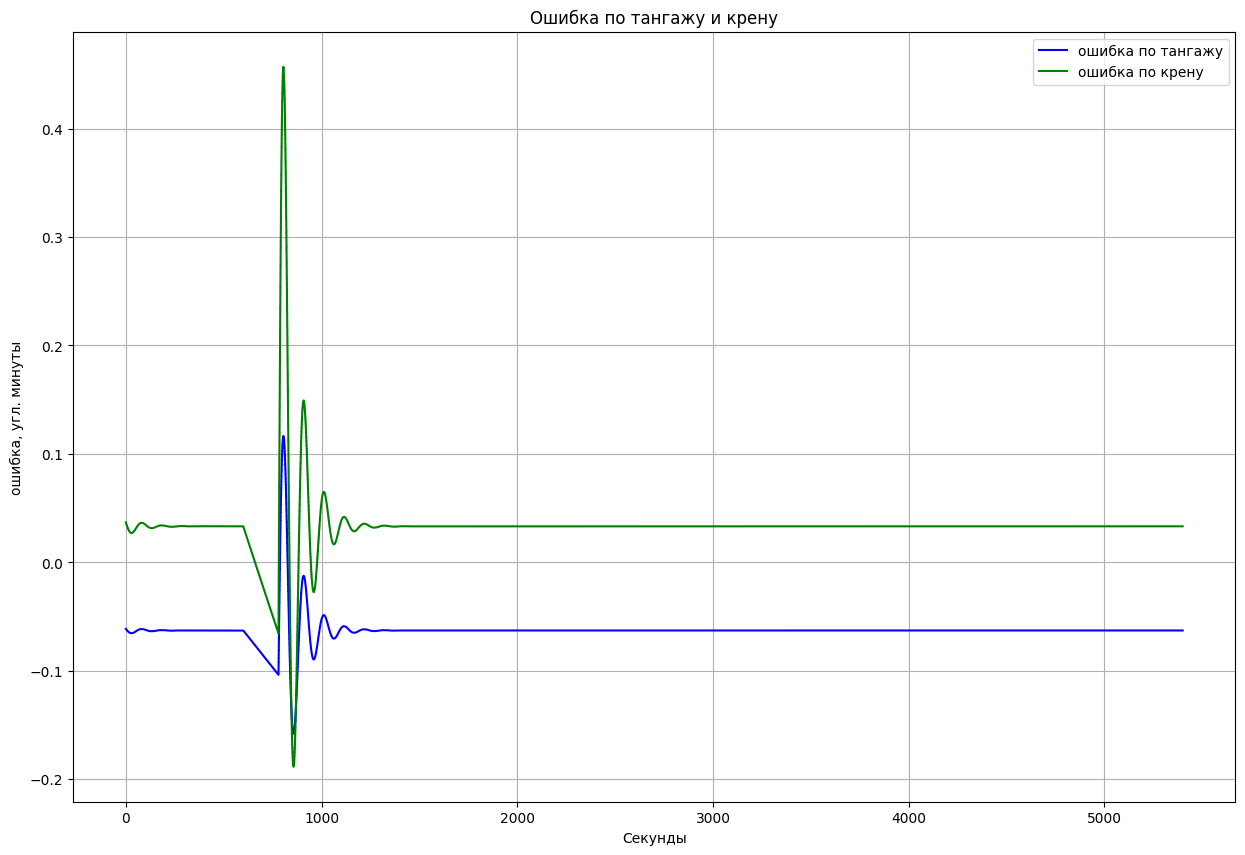

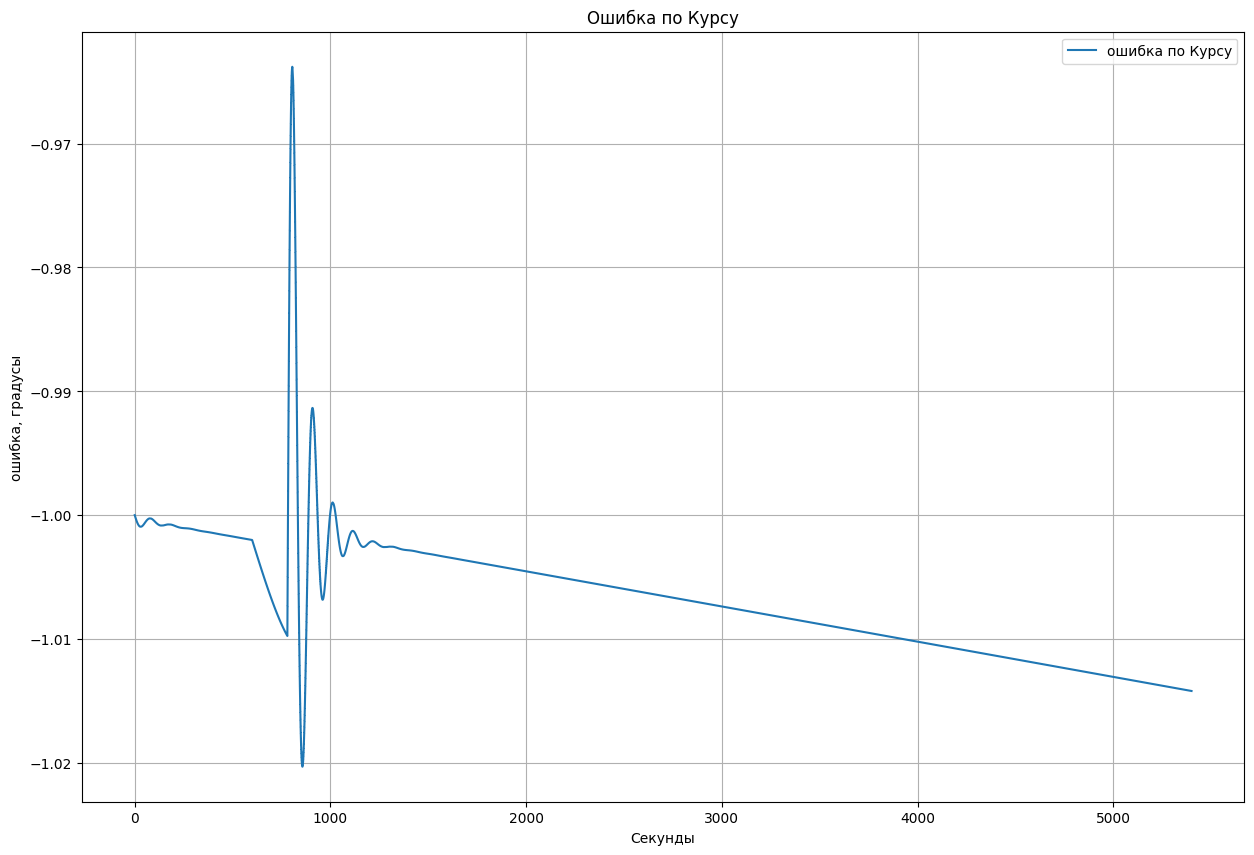

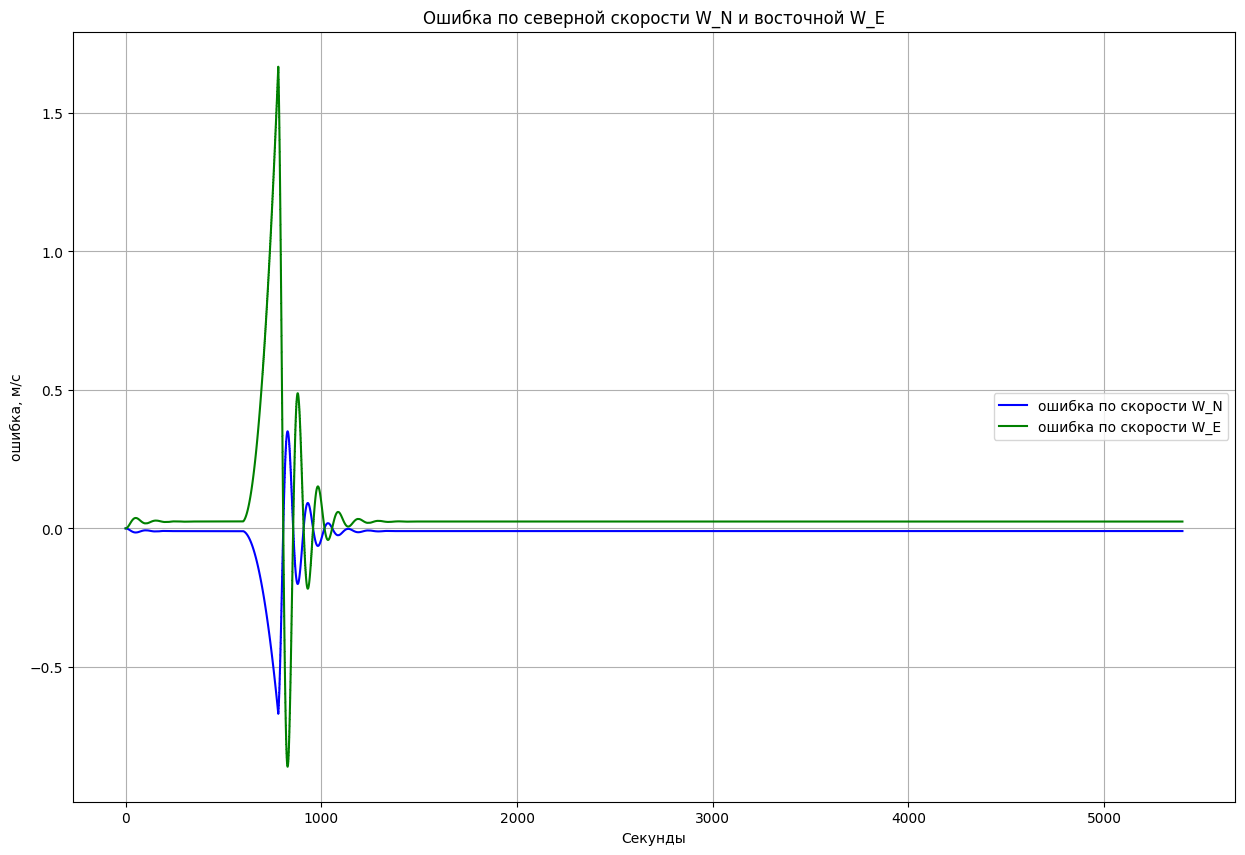

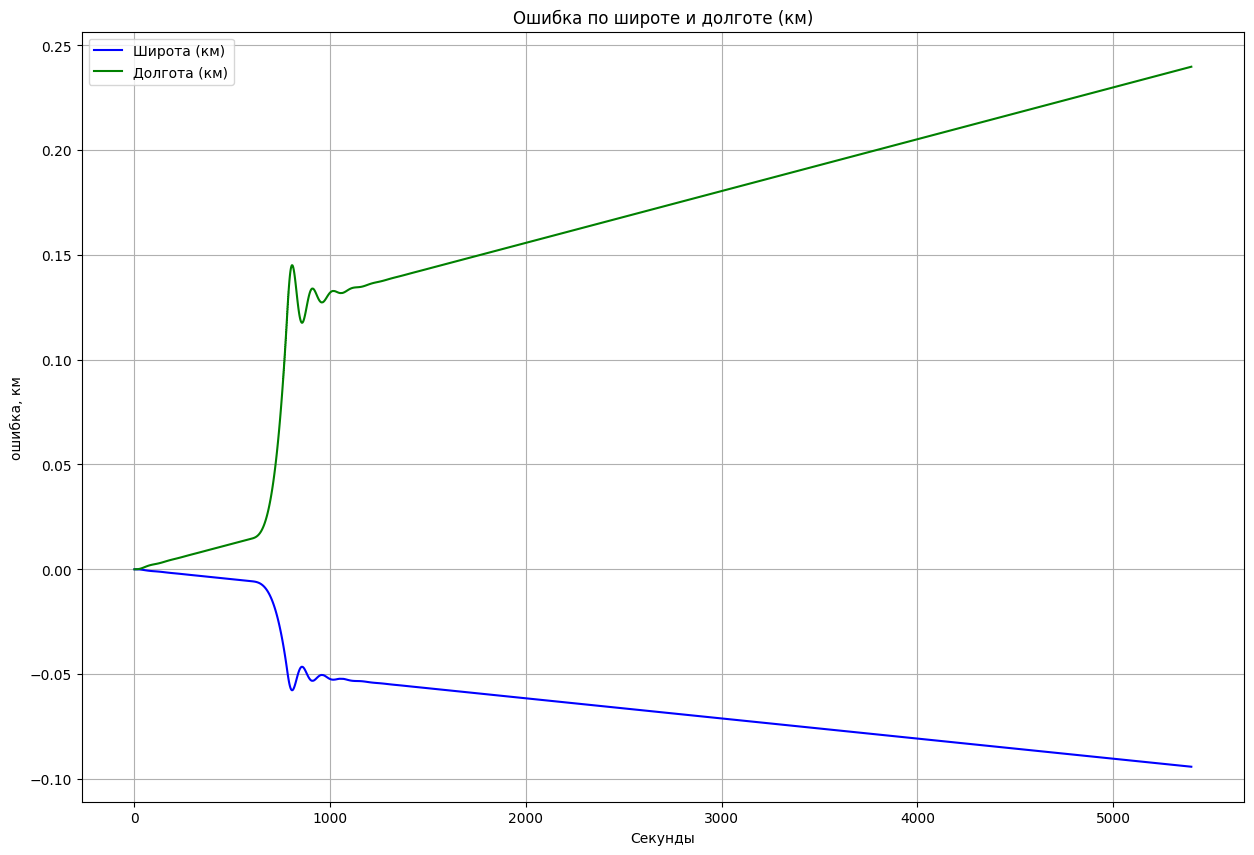

In [489]:
plt.figure(1)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.plot(t,out_pitch ,'b',t,out_roll ,'g')
plt.title("Ошибка по тангажу и крену")
plt.xlabel('Cекунды')
plt.ylabel('ошибка, угл. минуты')
plt.grid(True)
plt.legend(['ошибка по тангажу','ошибка по крену'], loc = 1)
plt.savefig('img2/углы.png')
plt.show()

plt.figure(2)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.plot(t,out_heading)
plt.title("Ошибка по Курсу")
plt.xlabel('Cекунды')
plt.ylabel('ошибка, градусы')
plt.grid(True)
plt.legend(['ошибка по Курсу'], loc = 1)
plt.savefig('img2/курс.png')
plt.show()

plt.figure(3)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.plot(t,out_W_N,'b',t,out_W_E,'g')
plt.title("Ошибка по северной скорости W_N и восточной W_E")
plt.xlabel('Cекунды')
plt.ylabel('ошибка, м/c')
plt.grid(True)
plt.legend(['ошибка по скорости W_N','ошибка по скорости W_E'], loc = 5)
plt.savefig('img2/скорости.png')
plt.show()

R = 6356.863 # км
queue_x = (out_Lat * ((np.pi / 180) * R)) - (out_Lat[0] * ((np.pi / 180) * R))
queue_y = (out_Lon * (np.pi / 180) * (R * np.cos(Lat))) - (out_Lon[0] * np.pi / 180 * (R * np.cos(Lat)))

plt.figure(4)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.plot(t,queue_x,'b',t,queue_y,'g')
plt.title("Ошибка по широте и долготе (км)")
plt.xlabel('Cекунды')
plt.ylabel('ошибка, км')
plt.grid(True)
plt.legend(['Широта (км)','Долгота (км)'], loc = 2)
plt.savefig('img2/координаты.png')
plt.show()